## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
#### 1. Compute the camera calibration using chessboard images

In [1]:
# import all required libraries
import numpy as np
import cv2
import glob
import math
import itertools
import matplotlib.pyplot as plt
#from lane_line import Line

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

In [2]:
# plotting helper functions
def plot_images(images, label=None, n_cols=5, cmap=None):
    """
    plot images in n_cols columns
    :param images 
    :param label image labels
    :param n_cols number of columns
    """
    n_rows = math.ceil(len(images)/n_cols)
 
    plt.figure(figsize=(20, n_rows*10/n_cols))   
    for i,image in enumerate(images):
        #image = image.squeeze()
        plt.subplot(n_rows, n_cols, i+1)  
        if label != None:
            plt.title("Output " + str(label[i]))
        plt.imshow(image, aspect='equal', cmap=cmap)
    plt.savefig(output_folder + "pipeline")
    plt.show()

def plot_compare_images(left_images, right_images, cmap=None):
    """
    compare two image list side by side
    """
    assert len(left_images) == len (right_images)
    mixed_images = list(itertools.chain.from_iterable(zip(left_images,right_images)))
    plot_images(mixed_images, n_cols=2, cmap=cmap)
     
def plot_histogram(labels, n_labels):
    """
    Exploration of the label distribution
    """
    plt.hist(labels, n_labels)
    plt.xlabel('Labels')
    plt.ylabel('Label Count')
    plt.title('Histogram')
    plt.show()

In [3]:
# Read in all calibration and test files and find corners
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
cal_files = glob.glob('./camera_cal/calibration*.jpg')
# Make a list of test images
test_files = glob.glob('./test_images/*.jpg')
output_folder = './output_images/'
# Make a list of challenge images
#test_files = glob.glob('./challenge_images/*.jpg')
#test_files = glob.glob('./shadow_images/*.jpg')

corner_images = []

# Step through the list and search for chessboard corners
for fname in cal_files:
    img = plt.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        corner_images.append(img)

#### Here you can see the calibration/chessboard images

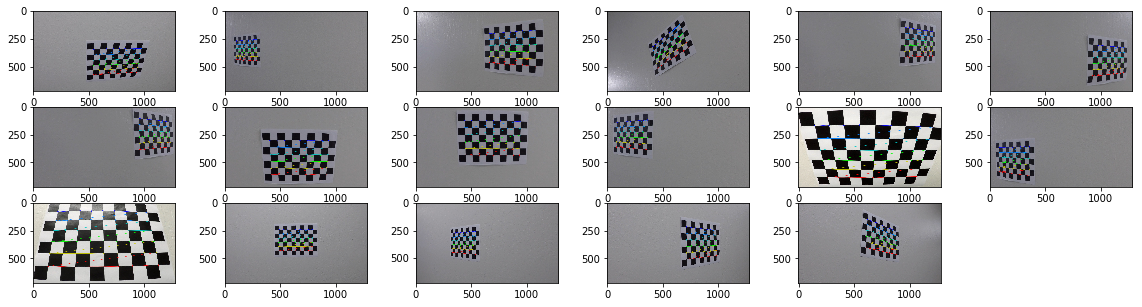

In [4]:
plot_images(corner_images, n_cols=6)

#### Read all calibration and test images and apply the undistort function

In [5]:
#Camera calibration, given object points, image points, and the shape of the grayscale image:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)

cal_images = []
cal_distorted_images = []
for fname in cal_files:
    img = plt.imread(fname)
    cal_distorted_images.append(img)
    cal_images.append(cv2.undistort(img, mtx, dist, None, mtx))

test_images = []
test_distorted_images = []
for fname in test_files:
    img = plt.imread(fname)
    test_distorted_images.append(img)
    test_images.append(cv2.undistort(img, mtx, dist, None, mtx))

#### Example of distorted and undistorted chessboard image

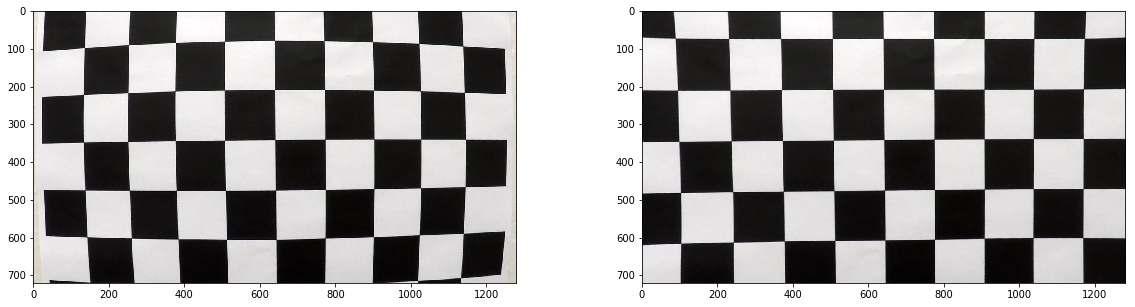

In [6]:
plot_compare_images([cal_distorted_images[0]], [cal_images[0]])

### Pipeline (single images)
#### 1. Example of distorted and undistorted test image
Below you can see the distorted image on the left and the undistorted on the right. Especially on the edges of the image you can see the difference

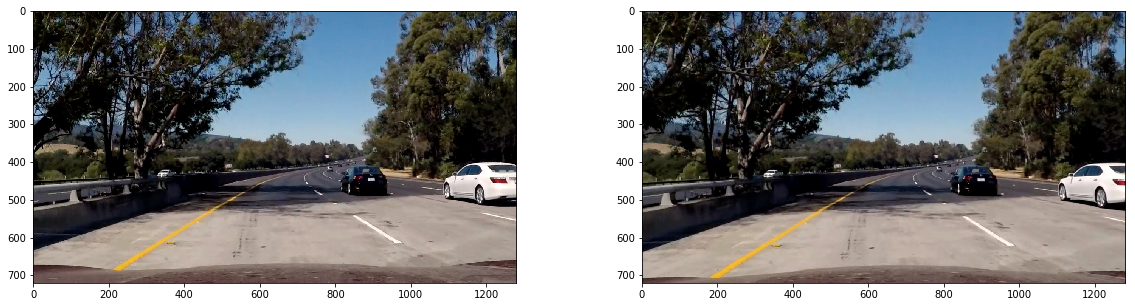

In [7]:
plot_compare_images([test_distorted_images[6]], [test_images[6]])

#### 2. Perspective Transformation
The function `get_perspective_matrices(img)` takes an input image and calculates the distortion matrix and it's inverse. These two can be used as inputs for the function `warp()` for my perspective transform to warp and get a bird-eye view and unwarp to get back to the normal view. The source and destination points are hardcoded and have the following values:

```
src = np.float32(
    [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
    [((img_size[0] / 6) - 10), img_size[1]],
    [(img_size[0] * 5 / 6) + 60, img_size[1]],
    [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
dst = np.float32(
    [[(img_size[0] / 4), 0],
    [(img_size[0] / 4), img_size[1]],
    [(img_size[0] * 3 / 4), img_size[1]],
    [(img_size[0] * 3 / 4), 0]])

```
This resulted in the following source and destination points:

| Source        | Destination   | 
|:-------------:|:-------------:| 
| 585, 460      | 320, 0        | 
| 203, 720      | 320, 720      |
| 1127, 720     | 960, 720      |
| 695, 460      | 960, 0        |

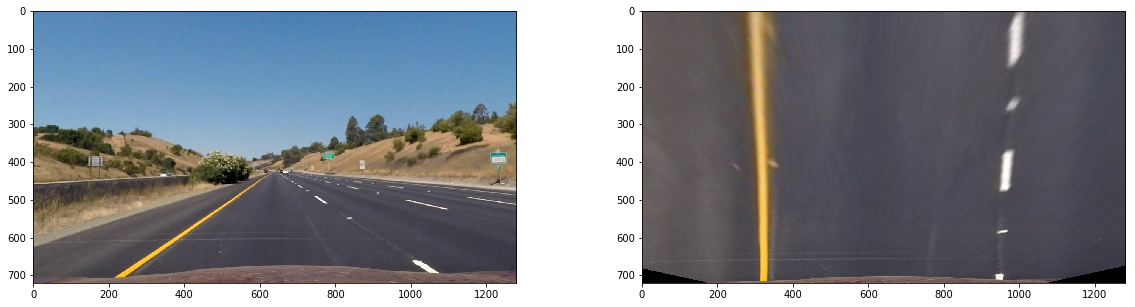

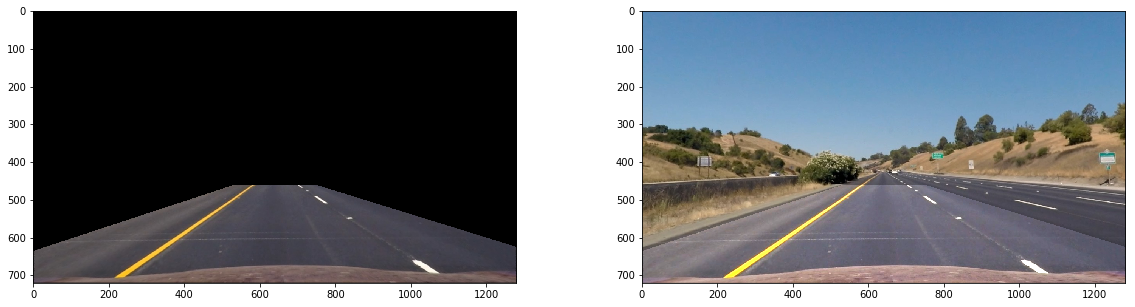

In [8]:
def get_perspective_matrices(img):
    """
    """
    # Grab the image shape
    img_size = (img.shape[1], img.shape[0])
    
    src = np.float32(
        [[(img_size[0] / 2) - 55, img_size[1] / 2 + 100],
        [((img_size[0] / 6) - 10), img_size[1]],
        [(img_size[0] * 5 / 6) + 60, img_size[1]],
        [(img_size[0] / 2 + 55), img_size[1] / 2 + 100]])
    dst = np.float32(
        [[(img_size[0] / 4), 0],
        [(img_size[0] / 4), img_size[1]],
        [(img_size[0] * 3 / 4), img_size[1]],
        [(img_size[0] * 3 / 4), 0]])      
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    # Return the resulting matrix and inverse
    return M, Minv

def warp(img, img_size, M):
    """
    Warp image with given transformation matrix
    """
    # Warp the image using OpenCV warpPerspective()
    return cv2.warpPerspective(img, M, img_size)

test_warp = test_images[0]
img_size = (test_warp.shape[1], test_warp.shape[0])
M, Minv = get_perspective_matrices(test_warp)
warped_img = warp(test_warp, img_size, M)
unwarped_img = warp(warped_img, img_size, Minv)
plot_compare_images([test_warp], [warped_img])
result = cv2.addWeighted(test_warp, 1, unwarped_img, 0.5, 0)
plot_compare_images([unwarped_img], [result])

#### Sobel and Color Transformation functions

In [9]:
def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def reject_outliers(data, m=2):
    """
    Reject outliers in data which are more than
    m * StandardDeviations away from the median
    """    
    return data[abs(data - np.median(data)) < m * np.std(data)] 

def select_color_code(func):
    def wrapper(img, code, *args, **kwargs):
        if code != None:
            img = cv2.cvtColor(img, code)
        func(img)
    return wrapper

def select_channel(img, channel=0):
    return None

                    
def channel_select(img, thresh=(0, 255), channel=2, code=cv2.COLOR_RGB2HLS):
    '''
    Function that thresholds the desired channel of selected color space 
    :param img: RGB input image
    :param thresh: threshold tupel from 0..255. thresh[0] < pixel <= thresh[1] are included
    :param channel: select color channel (e.g. H=0, L=1, S=2)
    :param code: 
    '''
    # use other color space than the original one
    if code != None:
        img = cv2.cvtColor(img, code)
    # select channel
    channel = img[:,:,channel]
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1  
    return binary_output


def abs_sobel(sobelx, sobely):
    '''
    Take the absolute values of the sobel gradient and add/scale them    
    '''
    abs_sobel = np.absolute(sobelx) + np.absolute(sobely)
    # Rescale back to 8 bit integer
    return np.uint8(255*abs_sobel/np.max(abs_sobel))   

def mag_sobel(sobelx, sobely):
    '''
    Take the magnitude value of the sobel gradients and scale them   
    '''
    magn = np.sqrt(sobelx**2 + sobely**2)
    # Rescale back to 8 bit integer
    return np.uint8(255 * magn/np.max(magn))

def dir_sobel(sobelx, sobely):
    '''
    Use arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient
    '''
    return np.arctan2(np.absolute(sobelx), np.absolute(sobely))    

def sobel_thresh(img, thresh=(0,255), sobel_kernel=9, orient='xy', func=abs_sobel, code=cv2.COLOR_RGB2GRAY):
    '''
    '''
    if code != None:
        # Convert to grayscale
        img = cv2.cvtColor(img, code)
    # Take the gradient in x and y separately
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    if orient == 'x':
        sobely = 0
    elif orient == 'y':
        sobelx = 0
    # apply function on sobel values, e.g. magnitude, direction
    scaled_sobel = func(sobelx, sobely)   
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    #binary_output = cv2.adaptiveThreshold(scaled_sobel,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,11,2)
    # Return the result
    return binary_output


def stack_binaries(first, second):
    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    return np.dstack(( first, second, np.zeros_like(first)))

def combine_binaries(first, second):    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(first)
    combined_binary[(first == 1) | (second == 1)] = 1
    return combined_binary

def _binaries(first, second):    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(first)
    combined_binary[(first == 1) & (second == 1)] = 1
    return combined_binary

In [10]:
# color and sobel conversions on original test images
h_binaries = [channel_select(img, thresh=(90,225), channel=0) for img in test_images]
l_binaries = [channel_select(img, thresh=(200,225), channel=1) for img in test_images]
s_binaries = [channel_select(img, thresh=(170,255), channel=2) for img in test_images]
r_binaries = [channel_select(img, thresh=(225,255), channel=0, code=None) for img in test_images]

In [11]:
# warp test images in different color spaces
test_warped = [warp(img, img_size, M) for img in test_images]
hls_warped = [cv2.cvtColor(img, cv2.COLOR_RGB2HLS) for img in test_warped]
hsv_warped = [cv2.cvtColor(img, cv2.COLOR_RGB2HSV) for img in test_warped]

r_warped = [img[:,:,0] for img in test_warped]
h_warped = [img[:,:,0] for img in hls_warped]
l_warped = [img[:,:,1] for img in hls_warped]
s_warped = [img[:,:,2] for img in hls_warped]
v_warped = [img[:,:,2] for img in hsv_warped]

In [12]:
# These are all kindes of binary treshold functions to play around with
h_bin_warped = [channel_select(img, thresh=(90,225), channel=0) for img in test_warped]
l_bin_warped = [channel_select(img, thresh=(120,150), channel=1) for img in test_warped]
s_bin_warped = [channel_select(img, thresh=(170,255), channel=2) for img in test_warped]
r_bin_warped = [channel_select(img, thresh=(222,255), channel=0, code=None) for img in test_warped]
v1_bin_warped = [channel_select(img, thresh=(220,255), channel=2, code=cv2.COLOR_RGB2HSV) for img in test_warped]
v2_bin_warped = [channel_select(img, thresh=(170,180), channel=2, code=cv2.COLOR_RGB2HSV) for img in test_warped]
v_bin_warped = [cv2.bitwise_or(r, s) for r,s in zip(v1_bin_warped, v2_bin_warped)]
l_bin_warped = [channel_select(img, thresh=(200,255), channel=1, code=cv2.COLOR_RGB2HLS) for img in test_warped]

mag_warped = [sobel_thresh(img, thresh=(50,100),func=mag_sobel, sobel_kernel=9) for img in test_warped]
dir_warped = [sobel_thresh(img, thresh=(0.7, 1.3),func=dir_sobel, sobel_kernel=15) for img in test_warped]
abs_warped = [sobel_thresh(img, thresh=(50, 200),func=abs_sobel, orient='x', sobel_kernel=9) for img in test_warped]

mag_abs_warped = [_binaries(r, l) for r,l in zip(abs_warped, mag_warped)]
abs_dir_warped = [_binaries(r, l) for r,l in zip(abs_warped, dir_warped)]
v_sobel_warped = [sobel_thresh(img, thresh=(50,200),func=mag_sobel, orient='x', sobel_kernel=9, code=None) for img in v_warped]
s_sobel_warped = [sobel_thresh(img, thresh=(80,200),func=mag_sobel, orient='x', sobel_kernel=15, code=None) for img in s_warped]

result = [cv2.bitwise_or(r, l) for r,l in zip(s_sobel_warped, v1_bin_warped)]
result = [cv2.bitwise_or(r, l) for r,l in zip(result, r_bin_warped)]
result = [cv2.bitwise_or(r, l) for r,l in zip(result, l_bin_warped)]
result = [cv2.bitwise_or(r, l) for r,l in zip(result, v_sobel_warped)]

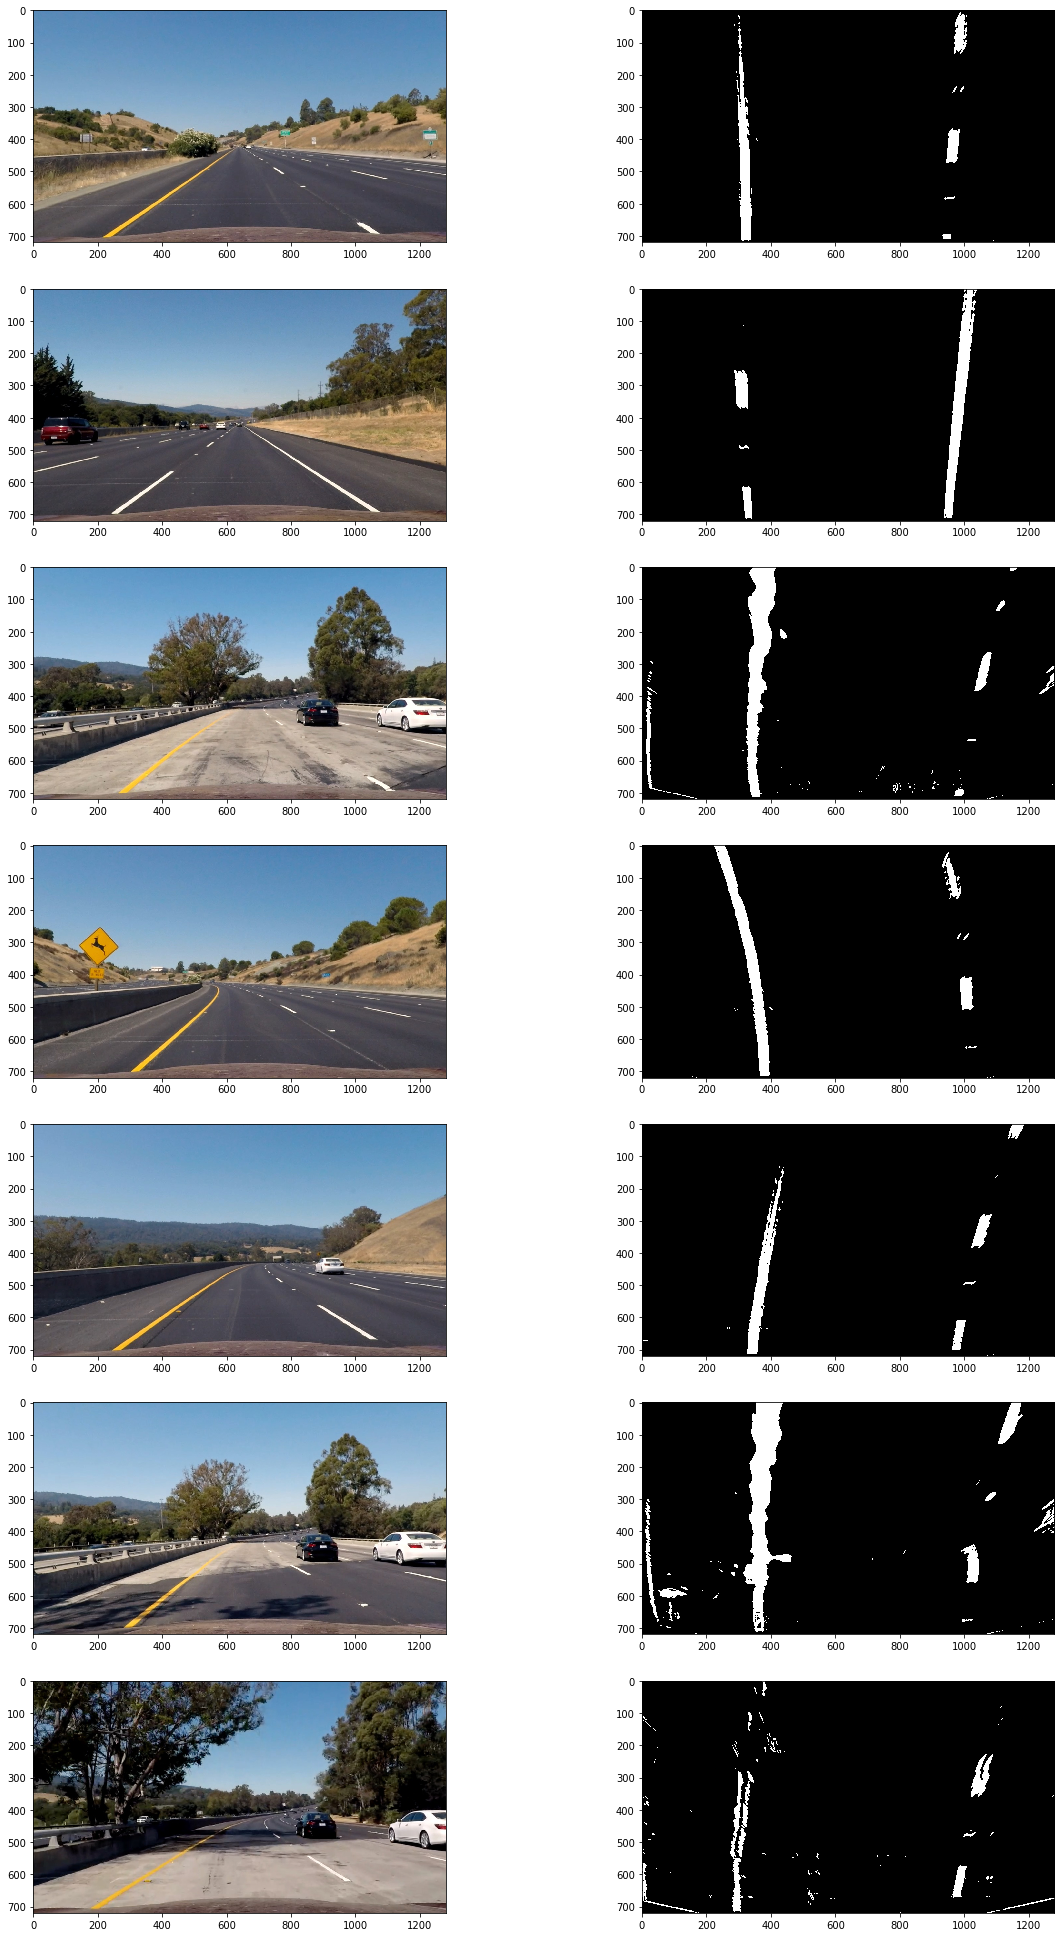

In [13]:
plot_compare_images(test_images[0:-1], result[0:-1], cmap='gray')

In [ ]:
plot_compare_images(test_images[-2:-1], r_binaries[-2:-1], cmap='gray')

In [ ]:
histograms = [np.sum(img[int(img.shape[0]/2):,:], axis=0) for img in result]
for h in histograms:
    plt.plot(h)
    plt.show()

In [ ]:
def binary2image(binary_image):
    return np.dstack((binary_image, binary_image, binary_image))*255

def nonzero_x_y(image):
    """
    Identify the x and y positions of all nonzero pixels in the image
    """ 
    nonzero = image.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    return nonzerox, nonzeroy

In [ ]:
def get_lane_base(binary_warped):
    """
    find the basepoints, midpoint, left and right lane base
    """
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2) 
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return midpoint, leftx_base, rightx_base

In [ ]:
binary_warped = result[3]
_, leftx_base, rightx_base = get_lane_base(binary_warped)
out_img = binary2image(binary_warped)
plt.imshow(out_img)
plt.show()

%run lane_line.py
left_line = Line()
right_line = Line()
left_line.fit_sliding_window(binary_warped, leftx_base, plot=True)
right_line.fit_sliding_window(binary_warped, rightx_base, plot=True)

binary_warped = result[0]
out_img = binary2image(binary_warped)

left_line.fit_previous(binary_warped)
right_line.fit_previous(binary_warped)
out_img = left_line.draw_poly(out_img)
out_img = right_line.draw_poly(out_img)
right_line.draw_fit(out_img)

plt.imshow(out_img)
plt.savefig(output_folder + "fit.png")
plt.show()

In [ ]:
def mask_lane(img, left_lane, right_lane):
    """
    Mask the lanes with a polygon
    """
    mask_img = np.zeros_like(img).astype(np.uint8)

    leftx = np.array([np.transpose(np.vstack([left_lane.fitx, left_lane.fity]))])
    rightx = np.array([np.flipud(np.transpose(np.vstack([right_lane.fitx, right_lane.fity])))])
    x = np.hstack((leftx, rightx))
    cv2.fillPoly(mask_img, np.int_([x]), (150, 255, 50))    
    img = cv2.addWeighted(img, 1, mask_img, 0.3, 0)
    return img

In [ ]:
%run lane_line.py
left_lane = Line()
right_lane = Line()

def process_image(img):
    """
    Processing image pipeline
    """       
    img_size = (img.shape[1], img.shape[0])
    # 1. undistort image
    img= cv2.undistort(img, mtx, dist, None, mtx)
    img = gaussian_blur(img, kernel_size=5)
    # 2. warp image
    M, Minv = get_perspective_matrices(img)
    warped  = warp(img, img_size, M)
    #plot_compare_images([img], [warped])
    # 3. filter lanes with color and sobel tresholds
    v_warped = cv2.cvtColor(warped, cv2.COLOR_RGB2HSV)[:,:,2]
    s_warped = cv2.cvtColor(warped, cv2.COLOR_RGB2HLS)[:,:,2]
    
    r_bin_warped = channel_select(warped, thresh=(215,255), channel=0, code=None) 
    s_bin_warped = channel_select(warped, thresh=(170,255), channel=2, code=cv2.COLOR_RGB2HLS)
    v_bin_warped = channel_select(warped, thresh=(220,255), channel=2, code=cv2.COLOR_RGB2HSV)
    l_bin_warped = channel_select(warped, thresh=(200,255), channel=1, code=cv2.COLOR_RGB2HLS)
    v_sobel_warped = sobel_thresh(v_warped, thresh=(50,200),func=mag_sobel, orient='x', sobel_kernel=9, code=None)
    s_sobel_warped = sobel_thresh(s_warped, thresh=(80,200),func=mag_sobel, orient='x', sobel_kernel=15, code=None)

    binary_warped = cv2.bitwise_or(r_bin_warped, v_bin_warped)
    binary_warped = cv2.bitwise_or(binary_warped, l_bin_warped)
    binary_warped = cv2.bitwise_or(binary_warped, v_sobel_warped)
    binary_warped = cv2.bitwise_or(binary_warped, s_sobel_warped)

    # 4. detect lanes and fit second order polynom
    _, leftx_base, rightx_base = get_lane_base(binary_warped)
    if left_lane.detected:
        left_lane.fit_previous(binary_warped)  
        #print("Detected == True")
    else:
        left_lane.fit_sliding_window(binary_warped, leftx_base)
    if right_lane.detected:
        right_lane.fit_previous(binary_warped)
    else:
        right_lane.fit_sliding_window(binary_warped, rightx_base)
    # draw lanes and print curvature
    out_img = binary2image(binary_warped)
    out_img = left_lane.draw_all(out_img)
    out_img = right_lane.draw_all(out_img)
    out_img = mask_lane(out_img, left_lane, right_lane)
    #plot_compare_images([binary_warped], [out_img])
    unwarped = warp(out_img, img_size, Minv)
    unwarped = left_lane.draw_curvature(unwarped, pos=(140, 50))
    unwarped = left_lane.draw_center_offset(unwarped, pos=(140, 100))
    unwarped = right_lane.draw_curvature(unwarped, pos=(740, 50))
    unwarped = right_lane.draw_center_offset(unwarped, pos=(740, 100))
    # Warp back
    #warped = cv2.addWeighted(out_img, 1, warped, 0.6, 0)
    result = cv2.addWeighted(img, 1, unwarped, 0.5, 0)
    #plot_compare_images([unwarped], [result])
    return result

plt.figure(figsize=(16,8))
plt.imshow(process_image(test_images[4]))
plt.show()
    

In [ ]:
left_lane = Line()
right_lane = Line()
lane_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4", audio=False)#.subclip(38,42)
#clip1 = VideoFileClip("challenge_video.mp4", audio=False).subclip(0,3)
white_clip = clip1.fl_image(process_image)
#white_clip.write_images_sequence("scene%i.jpg")
#white_clip.save_frame("frame.jpeg", t='00:00:500') 
%time white_clip.write_videofile(lane_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(lane_output))